In [3]:
import numpy as np
import tensorflow as tf
import tensorflow_text as text          # needed for loading bert from hub
from official.nlp import optimization   # to create AdamW optimizer
from matplotlib import pyplot as plt
from collections import defaultdict

tf.get_logger().setLevel('ERROR')
tf.__version__, tf.config.list_physical_devices('GPU')

('2.10.1', [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')])

In [1]:
from utils.preprocessing import preprocess

raw_ds = preprocess('tfcm')

Total number of news: 30339
Maximum number of news for each group in training set: 64
Minimum number of news for each group in training set: 3
Maximum number of news for each group in test set: 26
Minimum number of news for each group in test set: 3
Maximum number of times a news appears in training set: 22
Minimum number of times a news appears in training set: 0
Maximum number of times a news appears in test set: 11
Minimum number of times a news appears in test set: 0


In [3]:
valueRange = set(raw_ds['score'].values())
len(raw_ds['score']), len(valueRange)

(24160, 52)

In [9]:
countLine = 0
countID = defaultdict(int)
flag = False
countInLine = 0
flagIn = False
for line in raw_ds['test']:
    for ID in line:
        if ID not in raw_ds['score']:
            countID[ID] += 1
            flag = True
        else:
            flagIn = True
    if flag:
        countLine += 1
        flag = False
    if flagIn:
        countInLine += 1
        flag1 = False
countLine, countInLine, len(raw_ds['test']), len(countID)

(2460, 2590, 3000, 6179)

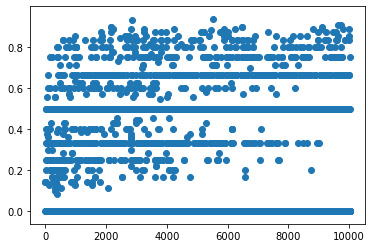

In [5]:
plt.scatter(range(len(raw_ds['score'])), raw_ds['score'].values())

In [19]:
np.array(raw_ds['train_reg'])[:,0]

array(['5187439', '176694', '175203', ..., '5539285', '179996', '9321204'],
      dtype='<U32')

In [4]:
train_data = np.vectorize(id2text:= lambda x: raw_ds['news'][x])(np.array(raw_ds['train_reg'])[:,0])
train_label = np.array(raw_ds['train_reg'])[:,1].astype(np.float32)
valid_data = np.vectorize(id2text)(np.array(raw_ds['valid_reg'])[:,0])
valid_label = np.array(raw_ds['valid_reg'])[:,1].astype(np.float32)

In [6]:
valid_label

array([1., 0., 0., ..., 0., 1., 1.], dtype=float32)

In [5]:
train_ds = tf.data.Dataset.from_tensor_slices((train_data, train_label))
valid_ds = tf.data.Dataset.from_tensor_slices((valid_data, valid_label))
len(train_ds), len(valid_ds)

(21744, 2416)

In [6]:
# tf.compat.v1.disable_eager_execution()
AUTOTUNE = tf.data.AUTOTUNE
BUFFER_SIZE = 512
BATCH_SIZE = 32

train_ds = train_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).cache().prefetch(AUTOTUNE)
valid_ds = valid_ds.batch(BATCH_SIZE).cache().prefetch(AUTOTUNE)
num_train = len(train_ds)
num_valid = len(valid_ds)
num_train, num_valid

(680, 76)

In [9]:
for x, y in train_ds.take(1):
    print(x[0].shape, x[1].shape, y.shape)
y

(32,) (32,) (32,)


<tf.Tensor: shape=(32,), dtype=float32, numpy=
array([0. , 0. , 0. , 0. , 1. , 1. , 1. , 0. , 0. , 1. , 1. , 1. , 1. ,
       1. , 1. , 0. , 0. , 1. , 1. , 1. , 1. , 1. , 0.2, 0.2, 0. , 1. ,
       1. , 0. , 1. , 1. , 0. , 1. ], dtype=float32)>

In [7]:
loss = tf.keras.losses.MeanSquaredError()
metrics = tf.metrics.MeanAbsoluteError()
epochs = 3
num_train_steps = num_train * epochs
num_warmup_steps = int(0.1 * num_train_steps)
init_lr = 1e-4
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')
callbacks = tf.keras.callbacks.TensorBoard(log_dir='logs')
title_units = 32
content_units = 128

In [8]:
from model import tfcm

regressioner = tfcm.build_regression_model(title_units, content_units, fine_tune=True)

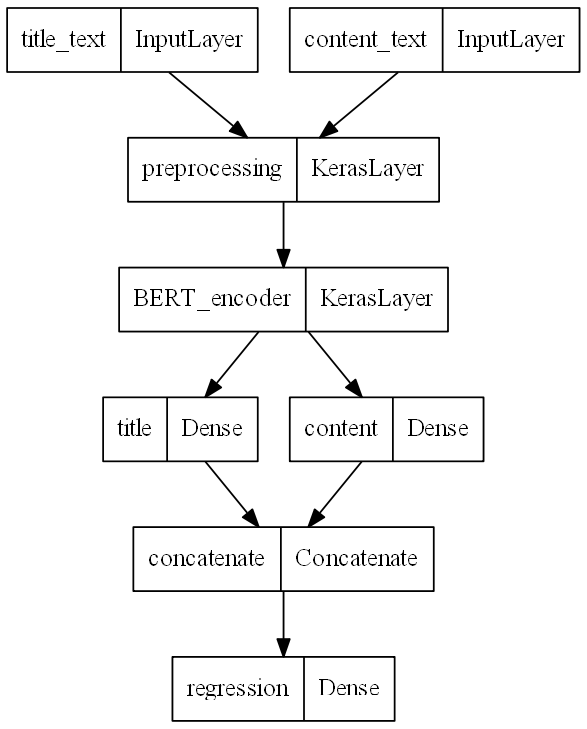

In [12]:
from utils.visualization import plot_structure, plot_history

plot_structure(regressioner, 'bert_regressioner.png')

In [11]:
regressioner.compile(optimizer=optimizer, loss=loss, metrics=metrics)
history = regressioner.fit(train_ds, validation_data=valid_ds, epochs=epochs, callbacks=[callbacks])

Epoch 1/3
680/680 [==============================] - 672s 974ms/step - loss: 0.2277 - mean_absolute_error: 0.4382 - val_loss: 0.2103 - val_mean_absolute_error: 0.4164
Epoch 2/3
680/680 [==============================] - 671s 987ms/step - loss: 0.2105 - mean_absolute_error: 0.4258 - val_loss: 0.2084 - val_mean_absolute_error: 0.4167
Epoch 3/3
680/680 [==============================] - 672s 989ms/step - loss: 0.2076 - mean_absolute_error: 0.4245 - val_loss: 0.2064 - val_mean_absolute_error: 0.4227


In [9]:
test_data = np.vectorize(id2text)(np.array(list(raw_ds['test_reg'])))
test_label = regressioner.predict(test_data)
test_label

194/194 [==============================] - 163s 821ms/step


array([[0.4597378 ],
       [0.32956466],
       [0.4577812 ],
       ...,
       [0.41048905],
       [0.23975748],
       [0.3256222 ]], dtype=float32)

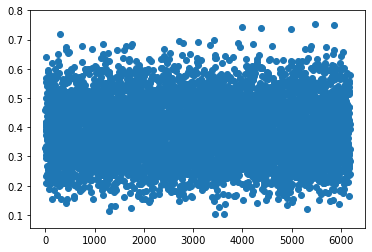

In [10]:
plt.scatter(range(len(test_label)), test_label)
plt.show()

In [22]:
scores = dict(raw_ds['score'], **dict(zip(raw_ds['test_reg'], test_label.flatten())))
scores

{'44374': 0.0,
 '44416': 0.14285714285714285,
 '2913537': 0.14285714285714285,
 '2913541': 0.14285714285714285,
 '3074529': 1.0,
 '49422': 1.0,
 '49429': 0.8,
 '7785735': 1.0,
 '132569': 1.0,
 '132604': 1.0,
 '132610': 1.0,
 '46844': 1.0,
 '2990192': 0.5,
 '2991404': 1.0,
 '2991427': 1.0,
 '2991450': 1.0,
 '2992028': 0.6666666666666666,
 '2993613': 0.6,
 '2957871': 1.0,
 '2958394': 1.0,
 '45884': 1.0,
 '2959890': 1.0,
 '46062': 1.0,
 '165623': 1.0,
 '165624': 1.0,
 '165671': 1.0,
 '8744403': 1.0,
 '165686': 1.0,
 '165699': 1.0,
 '165772': 1.0,
 '2745143': 1.0,
 '37582': 1.0,
 '2745231': 1.0,
 '2745306': 0.5,
 '151530': 0.4,
 '151551': 0.0,
 '151624': 0.0,
 '31314': 1.0,
 '31333': 1.0,
 '31341': 1.0,
 '31358': 1.0,
 '31368': 1.0,
 '140549': 1.0,
 '140567': 1.0,
 '140563': 1.0,
 '140624': 1.0,
 '3411064': 0.0,
 '59866': 0.0,
 '59921': 0.5,
 '3414600': 0.0,
 '84699': 0.0,
 '4871183': 0.0,
 '84702': 0.0,
 '5353284': 0.8333333333333334,
 '94600': 1.0,
 '5355512': 0.75,
 '3531193': 1.0,
 '64

In [23]:
test_data = [[scores[ID] for ID in line] for line in raw_ds['test']]
test_data

[[1.0, 1.0, 0.6666666666666666, 0.6666666666666666],
 [1.0, 1.0, 0.5, 0.44024694, 1.0],
 [0.55403036, 0.36807567, 0.43390974],
 [1.0, 1.0, 1.0],
 [1.0, 1.0, 1.0],
 [0.50864714, 1.0, 1.0],
 [1.0, 0.36076397, 0.875],
 [0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 0.7142857142857143, 1.0],
 [0.0, 0.0, 0.4],
 [1.0, 1.0, 1.0, 1.0],
 [0.55819494, 0.9375, 0.8823529411764706],
 [0.37689498,
  0.33370325,
  0.41751438,
  0.4092373,
  0.3381722,
  0.8333333333333334,
  0.8],
 [0.3262555, 0.3600236, 1.0],
 [0.407195, 0.41360715, 1.0, 1.0],
 [1.0, 1.0, 1.0],
 [1.0, 1.0, 0.32087108, 1.0, 1.0, 1.0],
 [0.41667145, 0.5451815, 0.3165273],
 [0.48257694, 0.3839464, 0.34255823],
 [0.0, 0.22911118, 0.29505593, 0.3682988, 0.34915662, 0.0],
 [1.0, 1.0, 1.0, 1.0, 1.0],
 [0.28190446, 0.3428457, 0.3937063, 0.0, 0.5],
 [0.5306864, 0.43224847, 1.0],
 [0.31297243, 0.21094902, 1.0, 1.0, 1.0, 0.3192345],
 [1.0, 0.2105437, 1.0, 1.0],
 [1.0, 0.46865115, 1.0, 0.3245108, 1.0],
 [0.41909036, 0.4223964, 0.5, 0.0, 0.5

In [19]:
maxlen = max(max(len(i) for i in test_data), max(len(i) for i in raw_ds['train']), max(len(i) for i in raw_ds['valid']))
maxlen

64

In [29]:
test_ds = tf.keras.preprocessing.sequence.pad_sequences(test_data, maxlen=maxlen, padding='post', value=0.5, dtype=np.float32)
test_ds

array([[1.        , 1.        , 0.6666667 , ..., 0.5       , 0.5       ,
        0.5       ],
       [1.        , 1.        , 0.5       , ..., 0.5       , 0.5       ,
        0.5       ],
       [0.55403036, 0.36807567, 0.43390974, ..., 0.5       , 0.5       ,
        0.5       ],
       ...,
       [0.2131391 , 1.        , 0.2794654 , ..., 0.5       , 0.5       ,
        0.5       ],
       [0.39196554, 0.30758706, 1.        , ..., 0.5       , 0.5       ,
        0.5       ],
       [0.27613512, 0.2402967 , 0.33888564, ..., 0.5       , 0.5       ,
        0.5       ]], dtype=float32)